In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 
# start = (datetime.today() - timedelta()).strftime("%Y%m%d") 
# print(start, today)
pd.options.display.float_format = '{:.6f}'.format

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cd drive/My Drive/algorithmtrading/pair_trading/Datas

/content/drive/My Drive/algorithmtrading/pair_trading/Datas


In [11]:
def one_day(temp,test_day):
    
    begin = np.where( np.array(temp.index) > str(test_day))[0][0]
    end = np.where( str(test_day+1) > np.array(temp.index) )[0][-1]
    
    if len(temp.iloc[begin:end])==0:
        print(test_day,'는 공휴일 입니다.')
    else:
        return temp.iloc[begin-1:end]

# 1. 과거 1분단위 데이터 받아오기

In [36]:
now = '20210129'

samsung_group = pd.read_pickle('KODEX 삼성그룹(m)_'+now)
kodex200 = pd.read_pickle('KODEX 200TR(m)_'+now)

temp =  pd.merge(left = samsung_group , right = kodex200, how = "inner", on = "체결시간")
temp = temp.set_index('체결시간')
temp.columns = ['samsung_group','volume','kodex200','volume']
temp = temp[['samsung_group','kodex200']]

temp['samsung_group']=abs(pd.to_numeric(temp['samsung_group']))
temp['kodex200']=abs(pd.to_numeric(temp['kodex200']))

temp['kodex200'] = temp['kodex200']
temp['spread'] = temp['samsung_group'] - temp['kodex200']
temp['samsung_group_cumret'] = np.log(temp['samsung_group']/temp['samsung_group'][0])
temp['kodex200_cumret'] = np.log(temp['kodex200']/temp['kodex200'][0])
mean = temp['spread'].rolling(window=10, center=False).mean()
std = temp['spread'].rolling(window=10, center=False).std()
temp['zscore'] = (temp['spread'] - mean)/std

temp

,samsung_group,kodex200,spread,samsung_group_cumret,kodex200_cumret,zscore
체결시간,,,,,,
20200102100000,6921,9390,-2469,0.000000,0.000000,nan
20200102100100,6941,9375,-2434,0.002886,-0.001599,nan
20200102100300,6941,9375,-2434,0.002886,-0.001599,nan
20200102100400,6931,9360,-2429,0.001444,-0.003200,nan
20200102100500,6926,9355,-2429,0.000722,-0.003734,nan
...,...,...,...,...,...,...
20210129151600,10245,13235,-2990,0.392230,0.343220,0.545204
20210129151700,10240,13230,-2990,0.391741,0.342842,0.422184
20210129151800,10255,13260,-3005,0.393205,0.345107,-0.850652


In [9]:
print(coint(temp['kodex200'],temp['samsung_group']))

(-3.4821500768684452, 0.03401089036866775, array([-3.89659034, -3.33621387, -3.04450822]))


# 2. 일 단위로 데이터 저장하기 + 당일 수익률 계산

In [ ]:
df = {}
calender = []
for date in range(20201021,20210129):
    if 20201231 < date < 20210100:
        continue
    temps = pd.DataFrame()
    temps = one_day(temp,date)
    try:      
        temps['samsung_group_dayret'] = np.log(temps['samsung_group']/temps['samsung_group'][0])
        temps['kodex200_dayret'] = np.log(temps['kodex200']/temps['kodex200'][0])
        temps['spread_cumret'] = temps['samsung_group_cumret'] -temps['kodex200_cumret']
        temps['spread_dayret']= temps['samsung_group_dayret'] - temps['kodex200_dayret'] 
        df[str(date)] = temps
        if len(temps) != 0:
            calender.append(str(date))
    except:
        pass
calender

In [ ]:
df['20210126']

# 3. 그래프 그리기

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

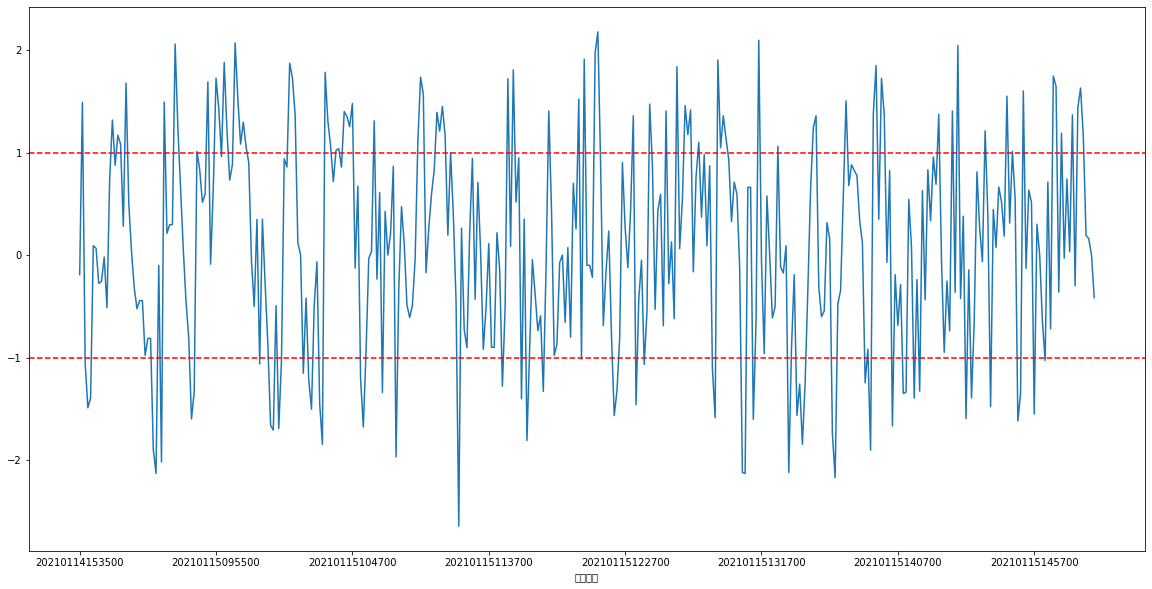

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

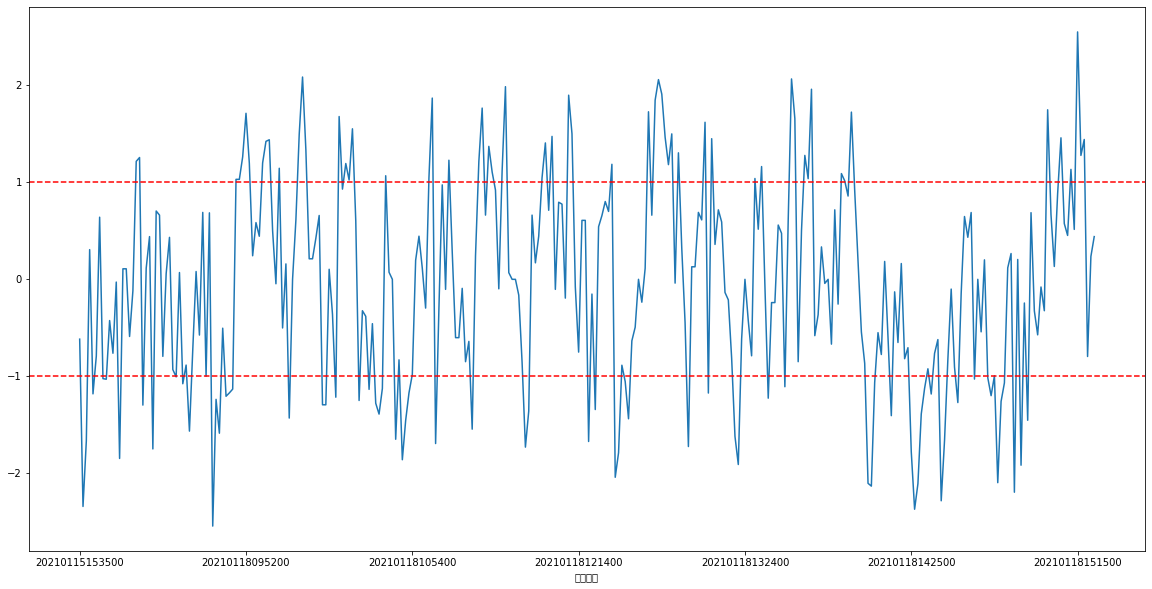

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

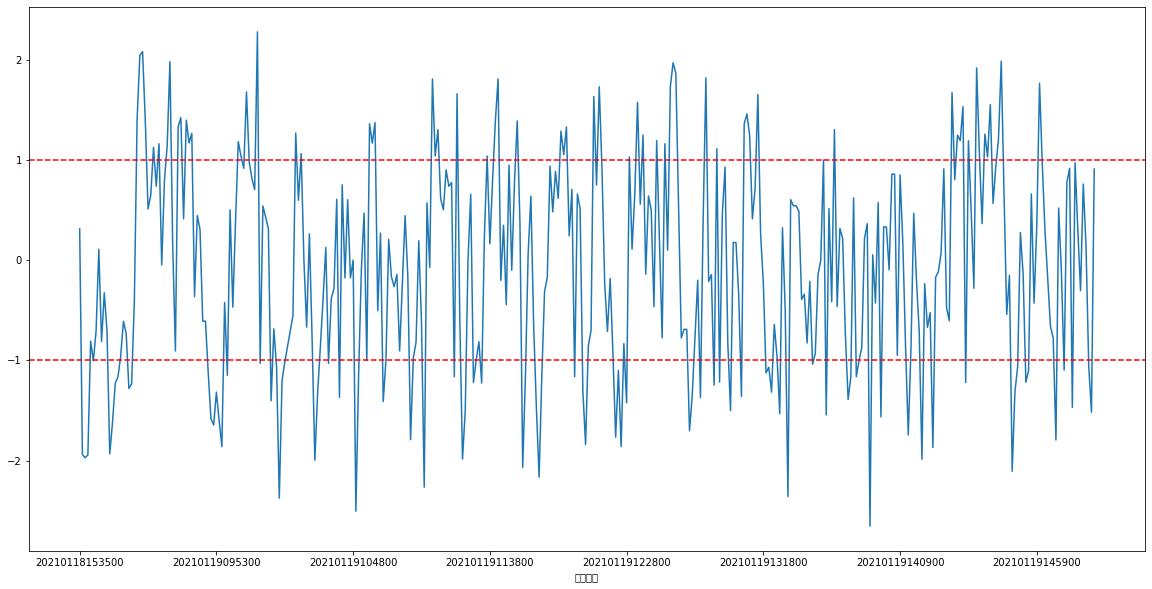

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

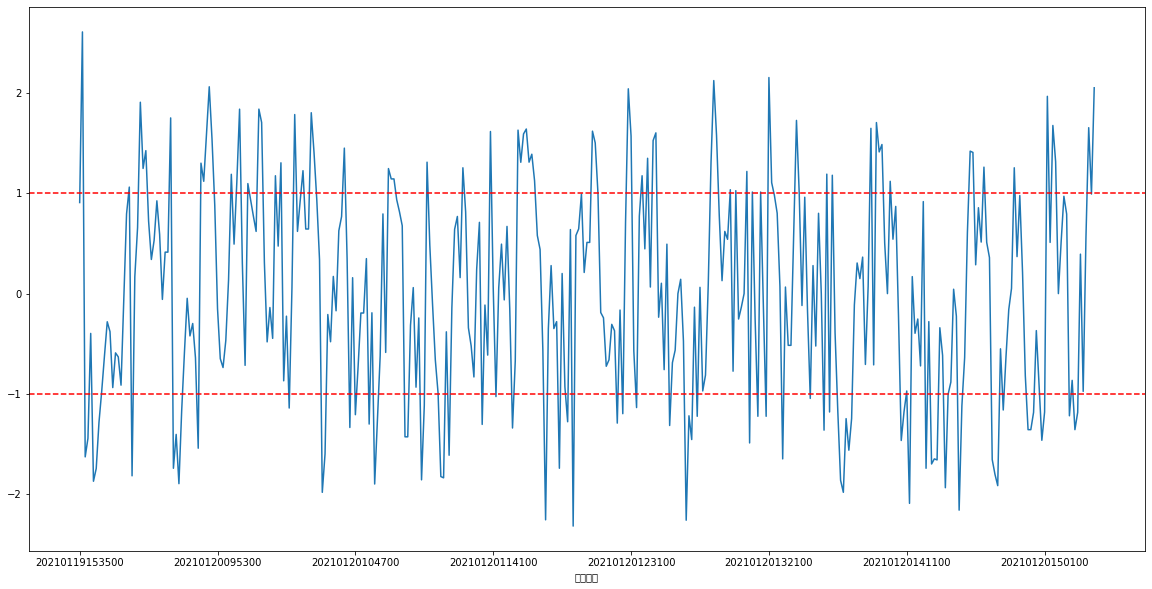

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

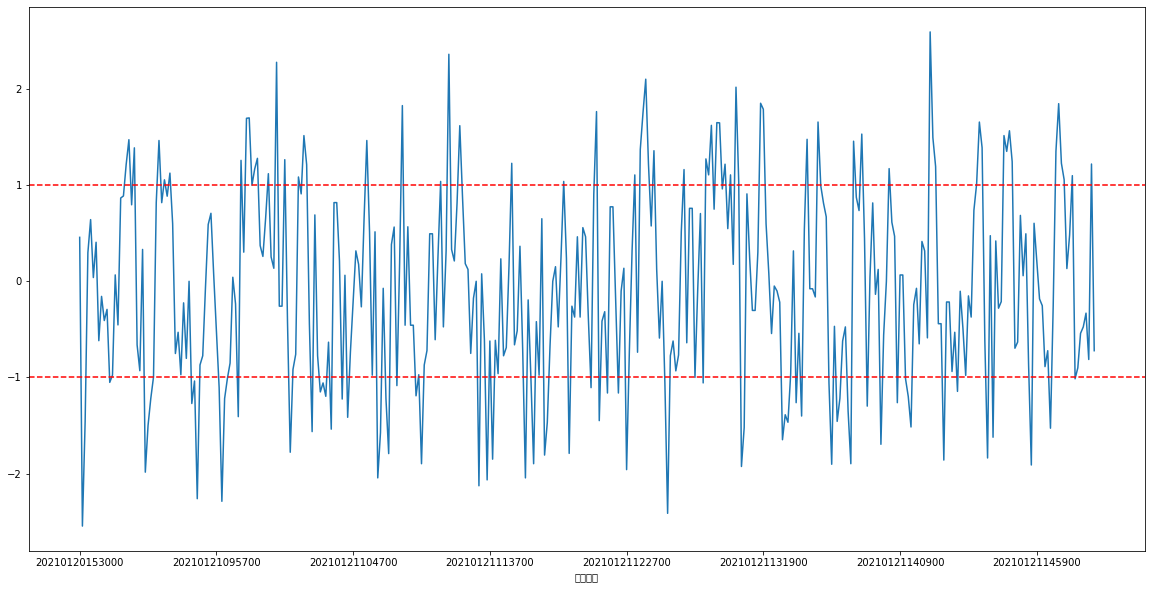

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

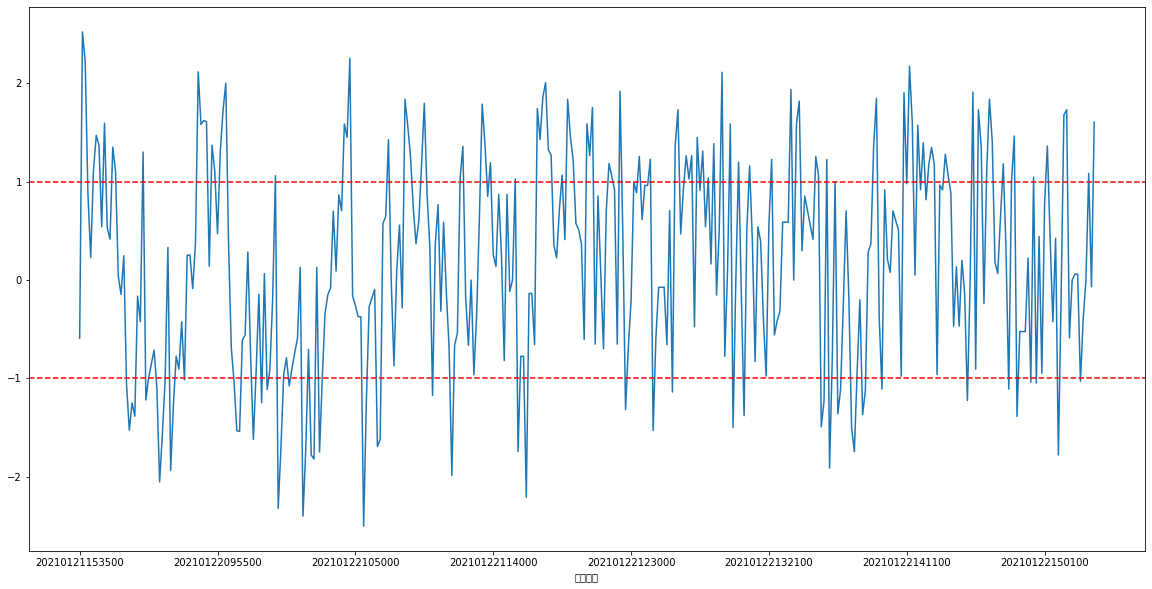

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

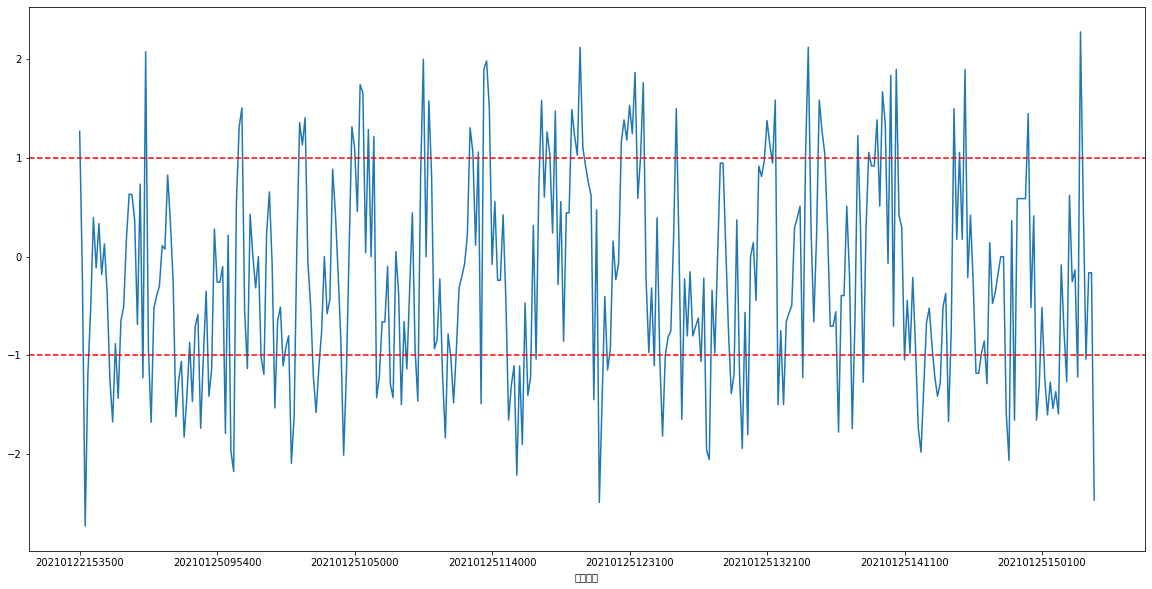

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

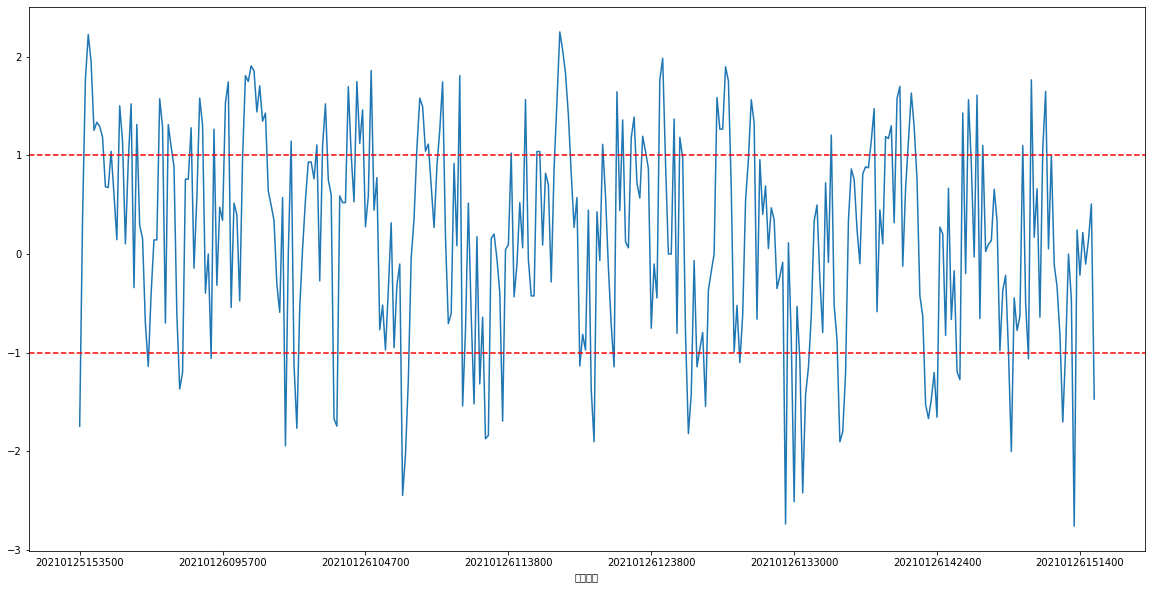

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

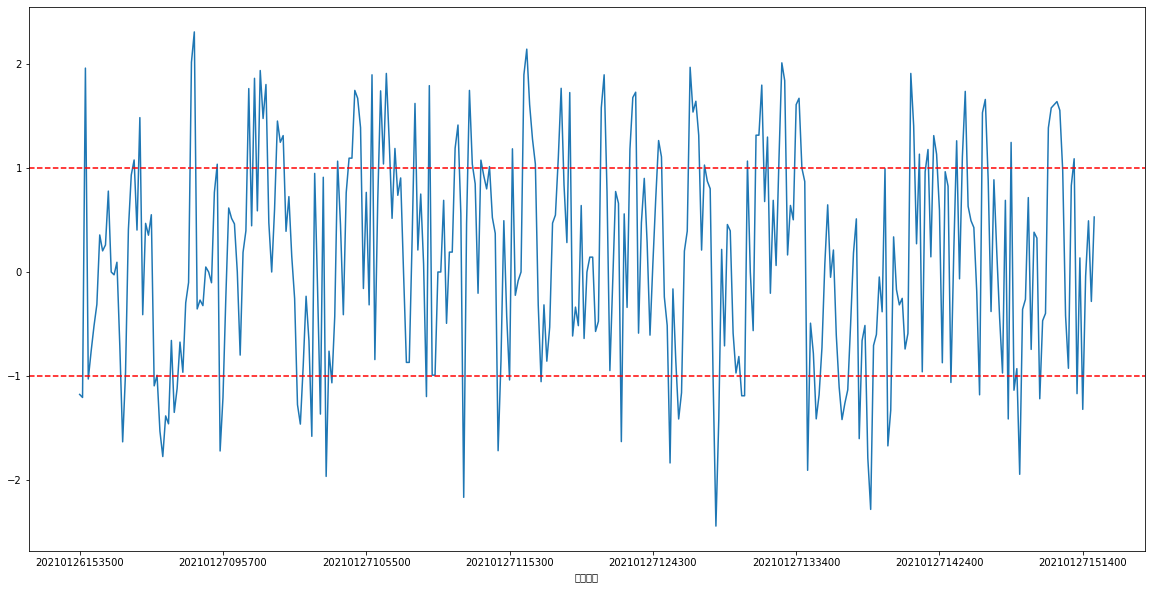

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

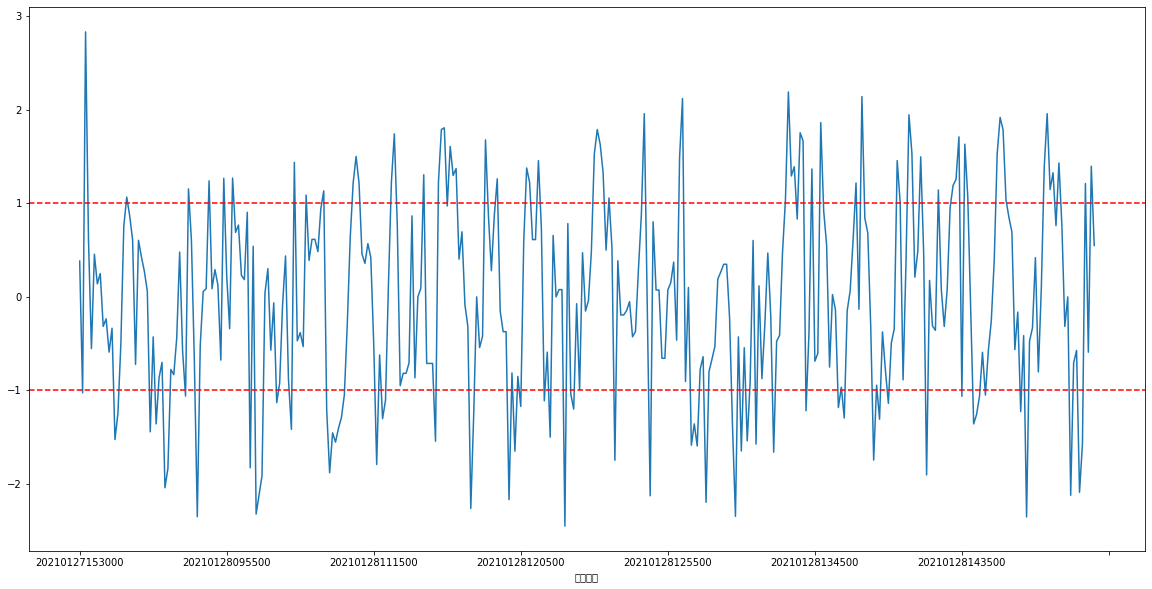

In [38]:
for date in calender[-10:]:
    plt.rcParams["figure.figsize"] = (20, 10)
    # df[date]['spread'].plot()
    # df[date]['ma10_spread'].plot()
    # temp_high = df[date]['ma10_spread'] +10
    # temp_low = df[date]['ma10_spread']-10
    # temp_high.plot(linestyle='--')
    # temp_low.plot(linestyle='--')
    # df[date]['samsung_group'].plot()
    # df[date]['kodex200'].plot()
    df[date]['zscore'].plot()
    plt.axhline((1), color='red', linestyle='--')
    plt.axhline((-1), color='red', linestyle='--')
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_te

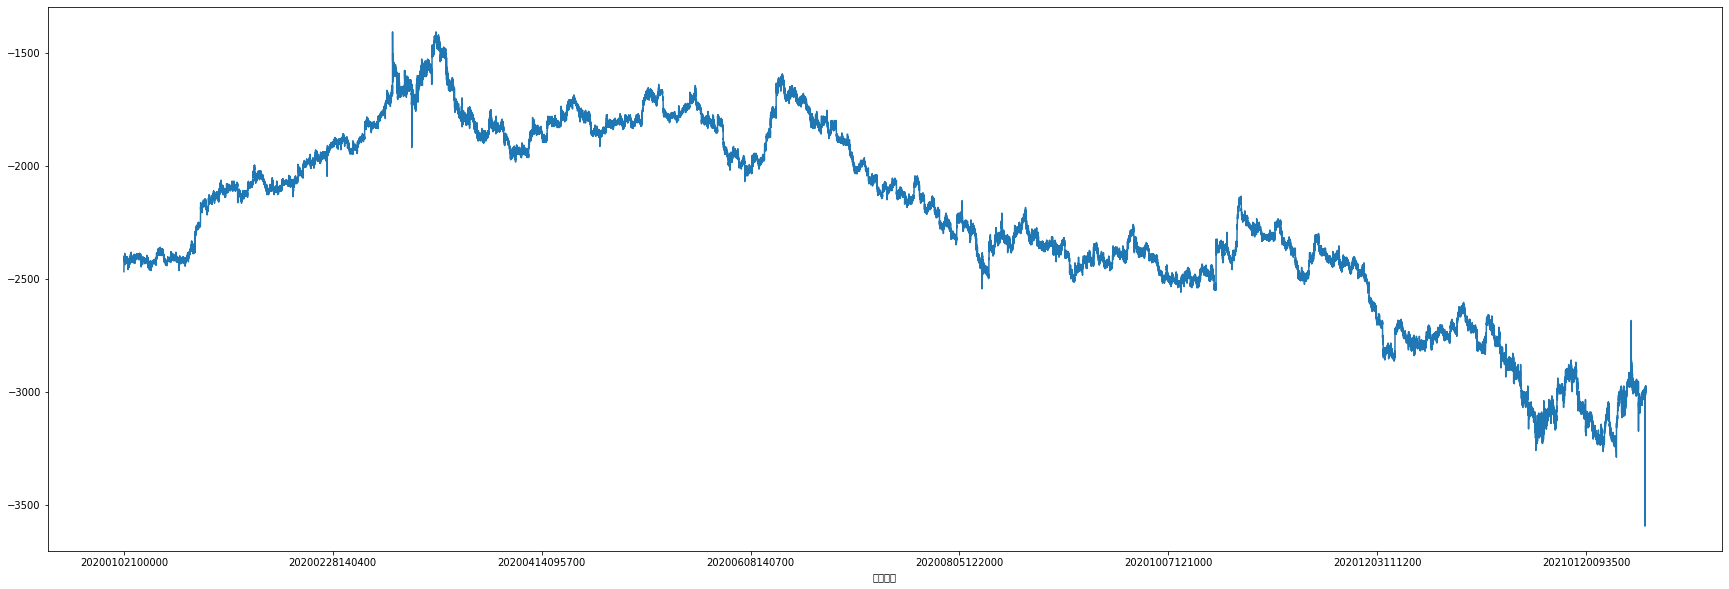

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
# temp['kodex200_cumret'].plot()
# temp['samsung_group_cumret'].plot()
temp['spread'].plot()

# 4. 스프레드 확인

In [ ]:
cd bidask

/content/drive/My Drive/algorithmtrading/pair_trading/bidask


In [ ]:
now = '20210128'

samsung_group_bidask = pd.read_pickle('KODEX 삼성그룹_'+now)
kodex200_bidask = pd.read_pickle('KODEX 200TR_'+now)

bidask =  pd.merge(left = samsung_group_bidask , right = kodex200_bidask, how = "inner", on = "time")
bidask.columns = ['samsung_group_bid','samsung_group_ask','kodex200_bid','kodex200_ask']
bidask['samsung_group_ask'] = abs(bidask['samsung_group_ask'])
bidask['samsung_group_bid'] = abs(bidask['samsung_group_bid'])
samsung_group_ask = bidask['samsung_group_ask']
samsung_group_bid = bidask['samsung_group_bid']
kodex200_ask = bidask['kodex200_ask']
kodex200_bid = bidask['kodex200_bid']
bidask

,samsung_group_bid,samsung_group_ask,kodex200_bid,kodex200_ask
time,,,,
095323,10660,10645,13600,13575
095326,10655,10645,13595,13570
095329,10655,10635,13590,13570
095332,10650,10630,13590,13570
095335,10650,10625,13595,13570
...,...,...,...,...
151919,10560,10555,13555,13515
151922,10560,10555,13555,13515
151925,10560,10555,13555,13515


## - bidask 스프레드

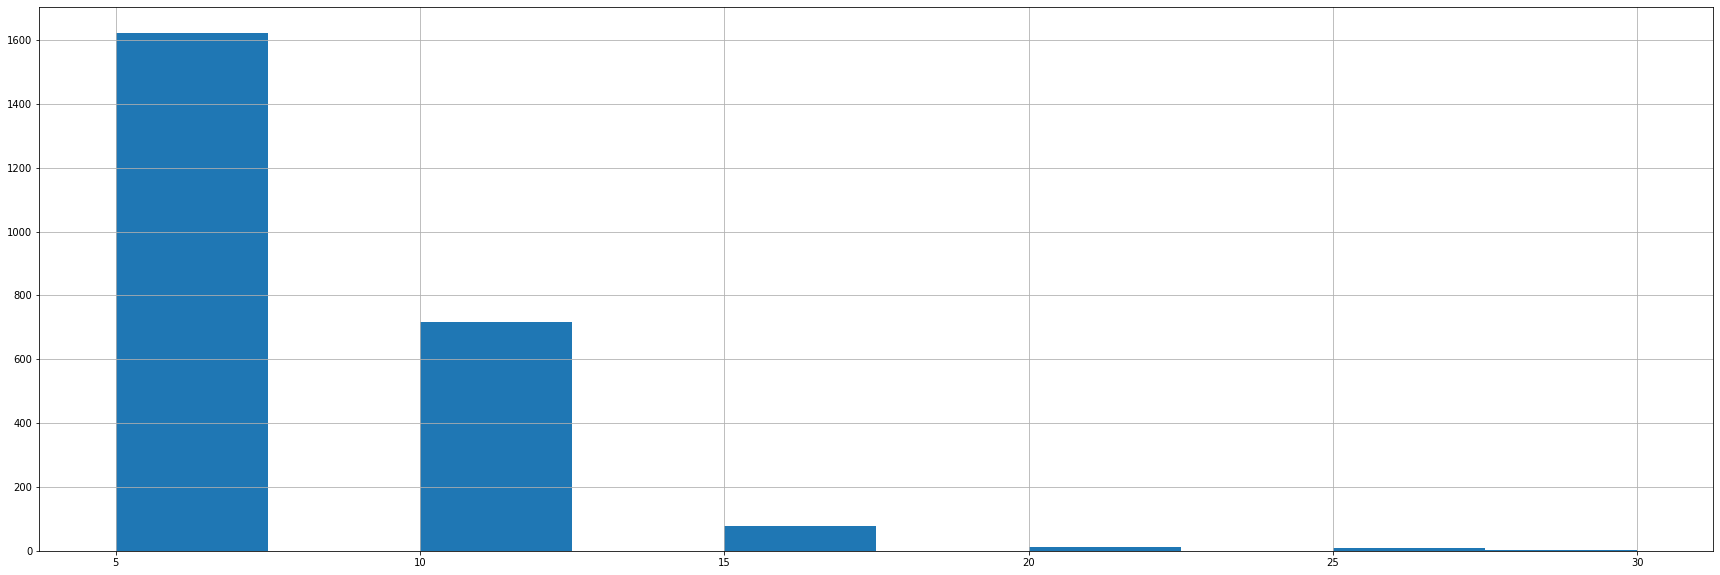

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
bidask_spread = samsung_group_bid-samsung_group_ask
bidask_spread.hist()

# samsung_group_ask_kodex200_bid spread freaquency (포지션시작)

2960    350
2965    292
2975    279
2970    267
2985    244
2980    211
2955    198
2990    131
2995     97
2950     64
3000     51
2920     37
2935     37
3005     34
2930     33
2915     30
2940     27
2945     26
3010     12
2925     11
2910     10
dtype: int64


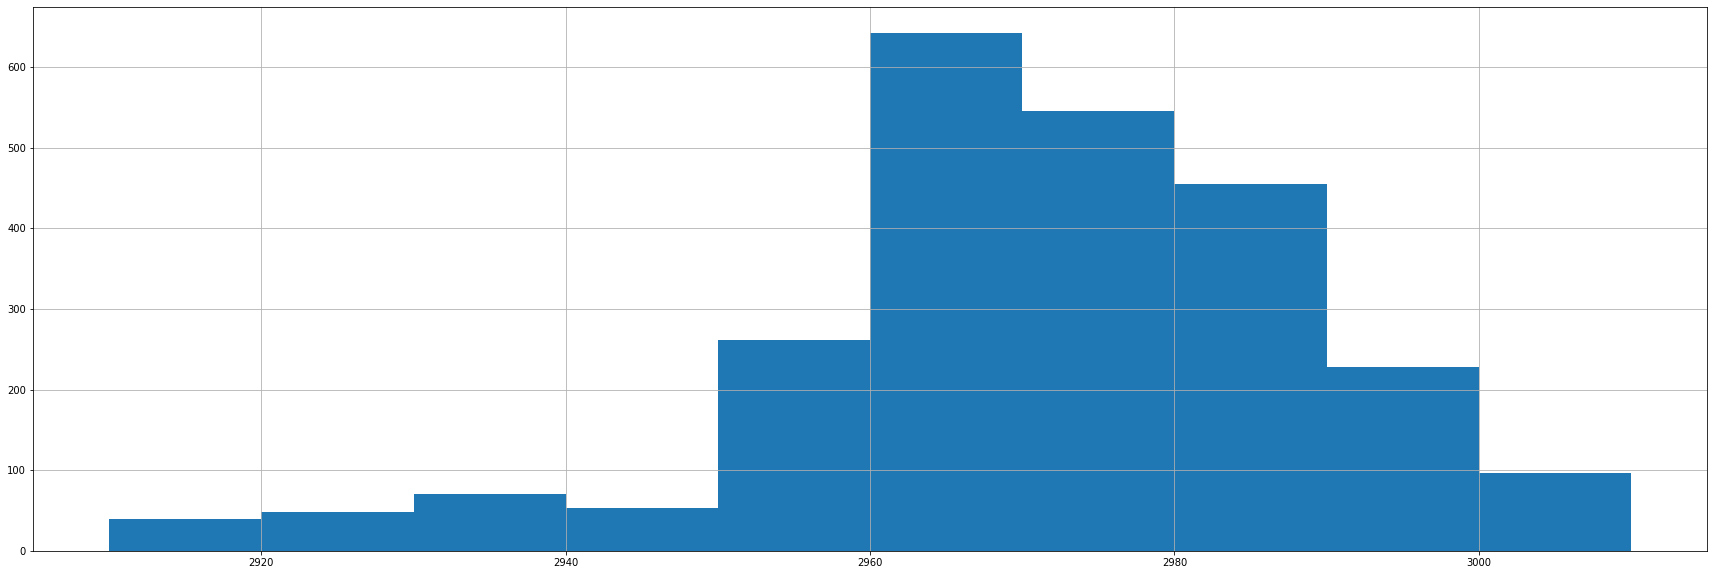

In [ ]:
short = kodex200_ask - samsung_group_bid
short.hist()
start = short.value_counts() 
print(start[:30])

# kodex200_ask_samsung_group_bid spread freaquency    (청산포지션)

-2995    356
-2990    282
-3000    275
-3005    259
-2985    231
-3015    193
-3010    179
-2975    171
-3020    170
-2980    143
-3025     59
-2970     55
-2965     15
-2930     10
-2940      7
-2955      6
-2960      6
-3030      6
-3035      5
-2935      4
-2920      3
-2945      3
-2950      2
-2925      1
dtype: int64


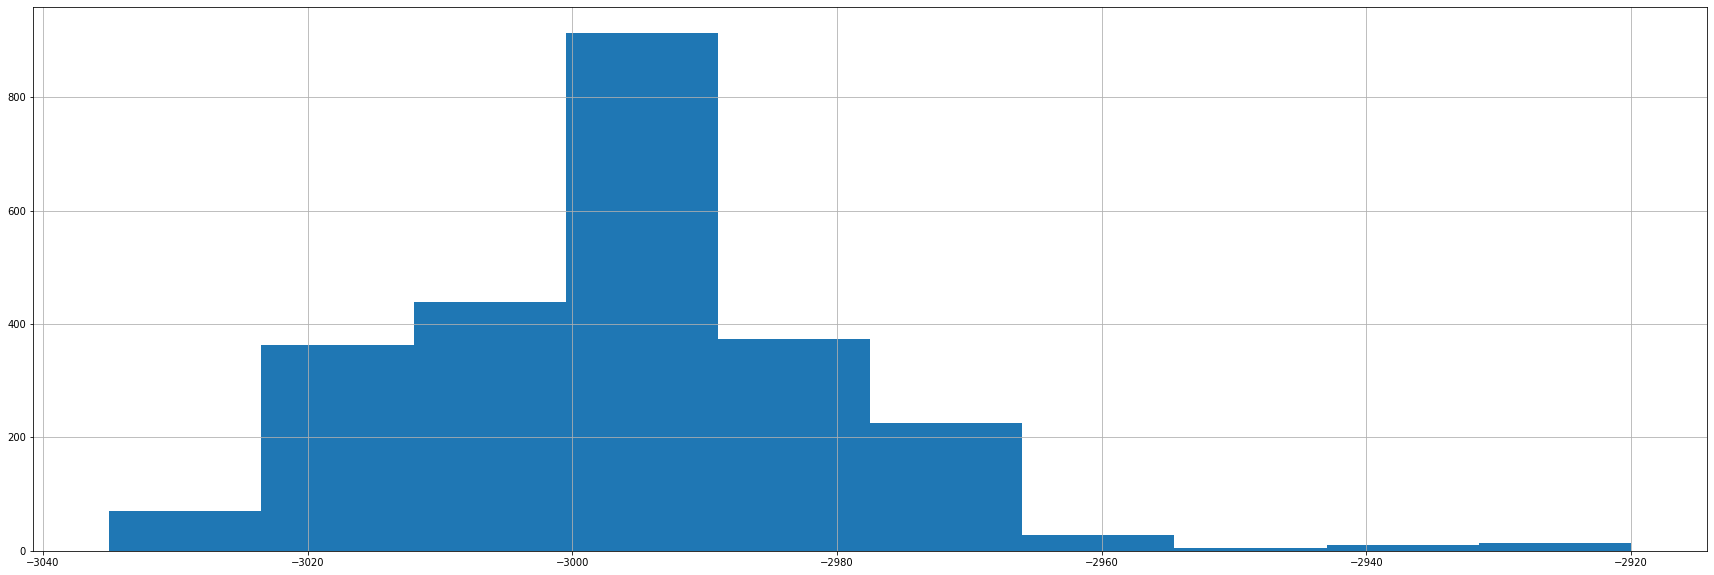

In [ ]:
long = samsung_group_ask - kodex200_bid
long.hist()
finish = long.value_counts() 
print(finish[:30])

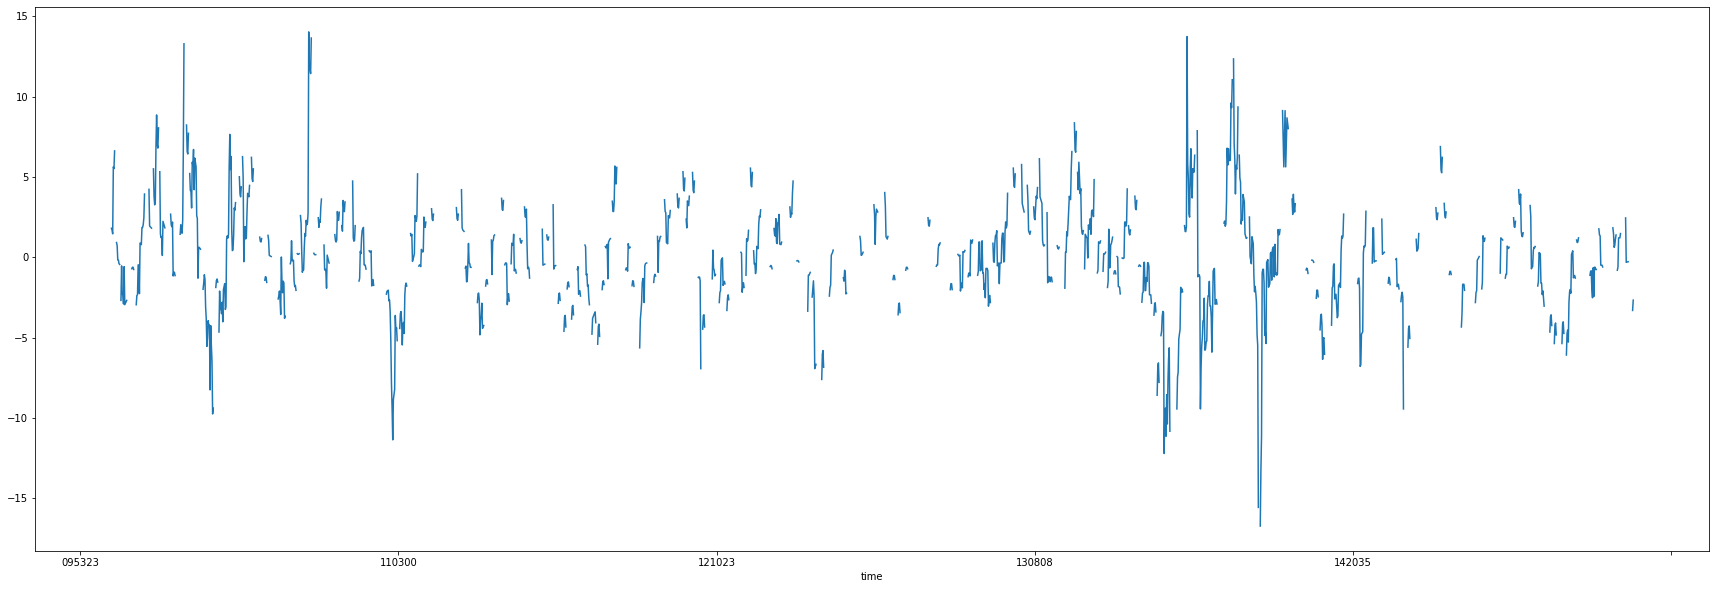

In [ ]:
# (short-3000).plot()
mean = short.rolling(window=50).mean()
std = short.rolling(window=5).std()
z = (short-mean)/std
z.plot()

# 시뮬레이션

In [ ]:
profit = 0
profits = {}

kodex = 25
samsung_group = 25

init = 25

lev = 1

spread_start = list(map(int,start.index))
spread_finish = list(map(int,finish.index))


for j in spread_start[:30]:
    for k in spread_finish[:30]:
        if j + k <= 3*4:
            continue
        profit = 0
        t = 0
        check = None
        kodex = 25
        samsung_group = 25
        for i in range(len(bidask)):
            if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= j and init <=samsung_group<= init*2-lev:
                kodex -= lev
                samsung_group += lev
                profit += bidask['kodex200_ask'].iloc[i]*lev - bidask['samsung_group_bid'].iloc[i]*lev
                print('shortstart',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)
                t += 2
                check = 'short'
            if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= k and samsung_group > init and check == 'short':
                profit += bidask['samsung_group_ask'].iloc[i]*(samsung_group - init) - bidask['kodex200_bid'].iloc[i]*(samsung_group-init)
                samsung_group = init
                kodex = init
                print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)       
                t += 2


            if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= k and init<= kodex<=init*2-lev:
                kodex += lev
                samsung_group -= lev
                profit += bidask['samsung_group_ask'].iloc[i]*lev - bidask['kodex200_bid'].iloc[i]*lev
                print('longstart',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)
                t += 2
                check = 'long'
            if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= j and kodex > init and check == 'long':
                profit += bidask['kodex200_ask'].iloc[i]*(kodex - init) - bidask['samsung_group_bid'].iloc[i]*(kodex-init)
                samsung_group = init
                kodex = init
                print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)       
                t += 2
        
        if check == 'short':
            profit += bidask['samsung_group_ask'].iloc[-1]*(samsung_group - init) - bidask['kodex200_bid'].iloc[-1]*(samsung_group-init)
            print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit) 
        if check == 'long':
            profit += bidask['kodex200_ask'].iloc[i]*(kodex - init) - bidask['samsung_group_bid'].iloc[i]*(kodex-init)
            print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)     

        profits[(j,k,t)] = profit -t*6
        print('-------------------------------------------------------------------------------------------------------------------')

profits = sorted(profits.items(), key=lambda x: x[1], reverse=True)
profits[:20]

Streaming output truncated to the last 5000 lines.
longstart 22 번째거래 /    ask: 43680   bid: 43855   profit: -3800
longstart 23 번째거래 /    ask: 43680   bid: 43860   profit: -3980
longstart 24 번째거래 /    ask: 43680   bid: 43855   profit: -4155
longfinish 2549 번째거래 /    ask: 44285   bid: 43920   profit: 4970
shortstart 2550 번째거래 /    ask: 44280   bid: 43920   profit: 5330
shortstart 2551 번째거래 /    ask: 44280   bid: 43920   profit: 5690
shortstart 2552 번째거래 /    ask: 44275   bid: 43920   profit: 6045
shortstart 2553 번째거래 /    ask: 44280   bid: 43920   profit: 6405
shortstart 2554 번째거래 /    ask: 44275   bid: 43920   profit: 6760
shortstart 2555 번째거래 /    ask: 44275   bid: 43920   profit: 7115
shortstart 2556 번째거래 /    ask: 44275   bid: 43920   profit: 7470
shortstart 2557 번째거래 /    ask: 44275   bid: 43920   profit: 7825
shortstart 2558 번째거래 /    ask: 44280   bid: 43920   profit: 8185
shortstart 2559 번째거래 /    ask: 44275   bid: 43920   profit: 8540
shortstart 2560 번째거래 /    ask: 44275   bid: 4

[((360, -270, 102), 3528),
 ((360, -275, 102), 3528),
 ((360, -255, 102), 3528),
 ((360, -260, 102), 3528),
 ((360, -265, 102), 3528),
 ((360, -285, 102), 3528),
 ((360, -250, 102), 3528),
 ((360, -230, 102), 3528),
 ((360, -280, 102), 3528),
 ((360, -245, 102), 3528),
 ((360, -235, 102), 3528),
 ((360, -240, 102), 3528),
 ((360, -220, 102), 3528),
 ((360, -225, 102), 3528),
 ((360, -300, 102), 3528),
 ((360, -305, 102), 3528),
 ((360, -310, 102), 3528),
 ((360, -290, 102), 3528),
 ((360, -215, 102), 3528),
 ((360, -295, 102), 3528)]

# 이동평균 스프레드 시물레이션

In [ ]:
profit = 0
profits = {}

kodex200 = 30
samsung_group = 30

init = 30

lev = 1

profit = 0
t = 0
check = None

dfj = []
dfk = []
tempk = 0
tempj = 0
for i in range(len(bidask)):
    short = int(bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i])
    long =int(bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i])

    dfj.append(short)
    dfk.append(long)   

    if i <= 200:
        continue
    
    del dfj[0]
    del dfk[0]

    j = pd.Series(dfj)
    k = pd.Series(dfk)
    j = j.rolling(window=200).mean()
    k = k.rolling(window=200).mean()

    if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= k.iloc[-1]+100 and init <=samsung_group<= init*2-lev:
        kodex200 -= lev
        samsung_group += lev
        profit += bidask['kodex200_ask'].iloc[i]*lev - bidask['samsung_group_bid'].iloc[i]*lev
        print('shortstart',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)
        print(kodex200,samsung_group)
        t += 2
        check = 'short'
        tempk = bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i]
    if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= -tempk+100 and samsung_group > init and check == 'short':
        profit += bidask['samsung_group_ask'].iloc[i]*(samsung_group - init) - bidask['kodex200_bid'].iloc[i]*(samsung_group-init)
        samsung_group = init
        kodex200 = init
        print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)       
        t += 2


    if bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i] >= j.iloc[-1]+100 and init<= kodex200<=init*2-lev:
        kodex200 += lev
        samsung_group -= lev
        profit += bidask['samsung_group_ask'].iloc[i]*lev - bidask['kodex200_bid'].iloc[i]*lev
        print('longstart',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit)
        print(kodex200,samsung_group,j.iloc[-1])
        t += 2
        check = 'long'
        tempj = bidask['samsung_group_ask'].iloc[i] - bidask['kodex200_bid'].iloc[i]
        continue
    if bidask['kodex200_ask'].iloc[i] - bidask['samsung_group_bid'].iloc[i] >= -tempj+100 and kodex200 > init and check == 'long':
        profit += bidask['kodex200_ask'].iloc[i]*(kodex200 - init) - bidask['samsung_group_bid'].iloc[i]*(kodex200-init)
        samsung_group = init
        kodex200 = init
        print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)       
        t += 2

if check == 'short':
    profit += bidask['samsung_group_ask'].iloc[-1]*(samsung_group - init) - bidask['kodex200_bid'].iloc[-1]*(samsung_group-init)
    print('shortfinish',i,'번째거래 / ','  ask:',bidask['samsung_group_ask'].iloc[i],'  bid:', bidask['kodex200_bid'].iloc[i],'  profit:',profit) 
    print(kodex200,samsung_group)
if check == 'long':
    profit += bidask['kodex200_ask'].iloc[i]*(kodex200 - init) - bidask['samsung_group_bid'].iloc[i]*(kodex200-init)
    print('longfinish',i,'번째거래 / ','  ask:',bidask['kodex200_ask'].iloc[i],'  bid:', bidask['samsung_group_bid'].iloc[i],'  profit:',profit)    
    print(kodex200,samsung_group)
print(profit)

0


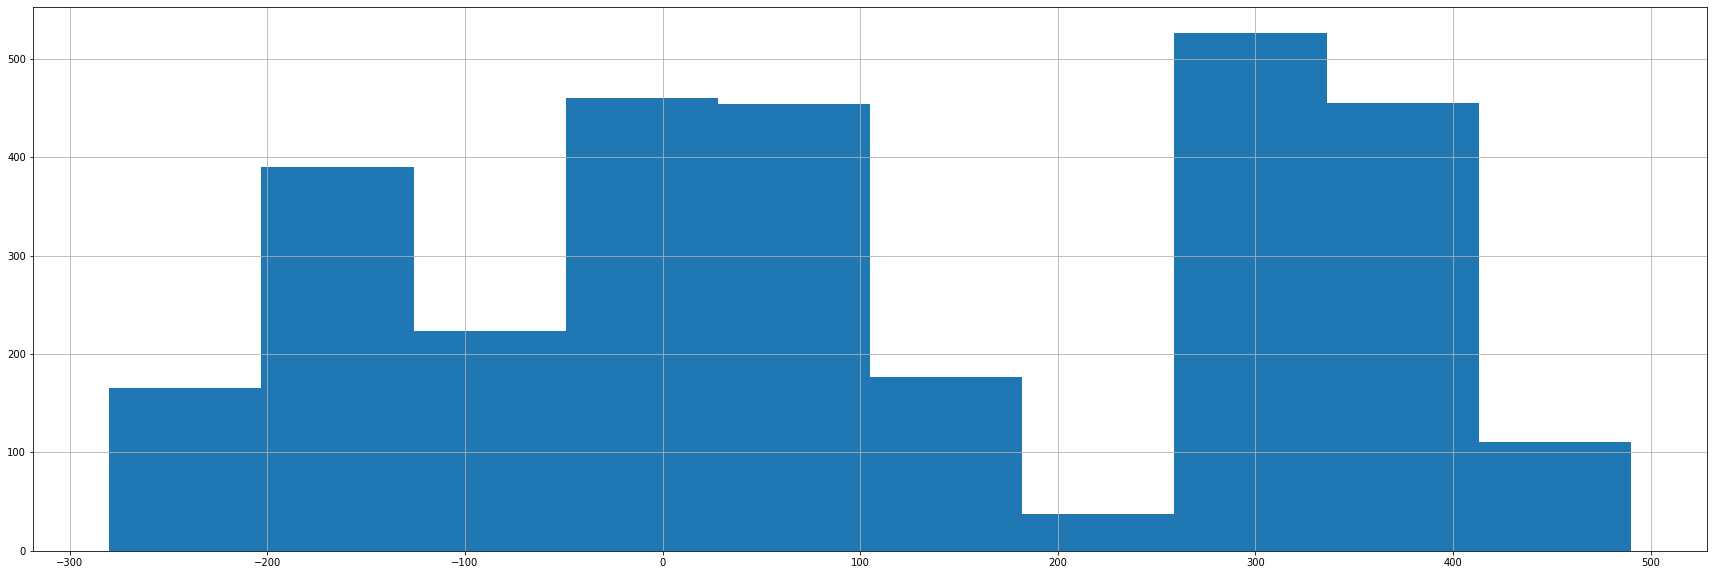

In [ ]:
short.hist()

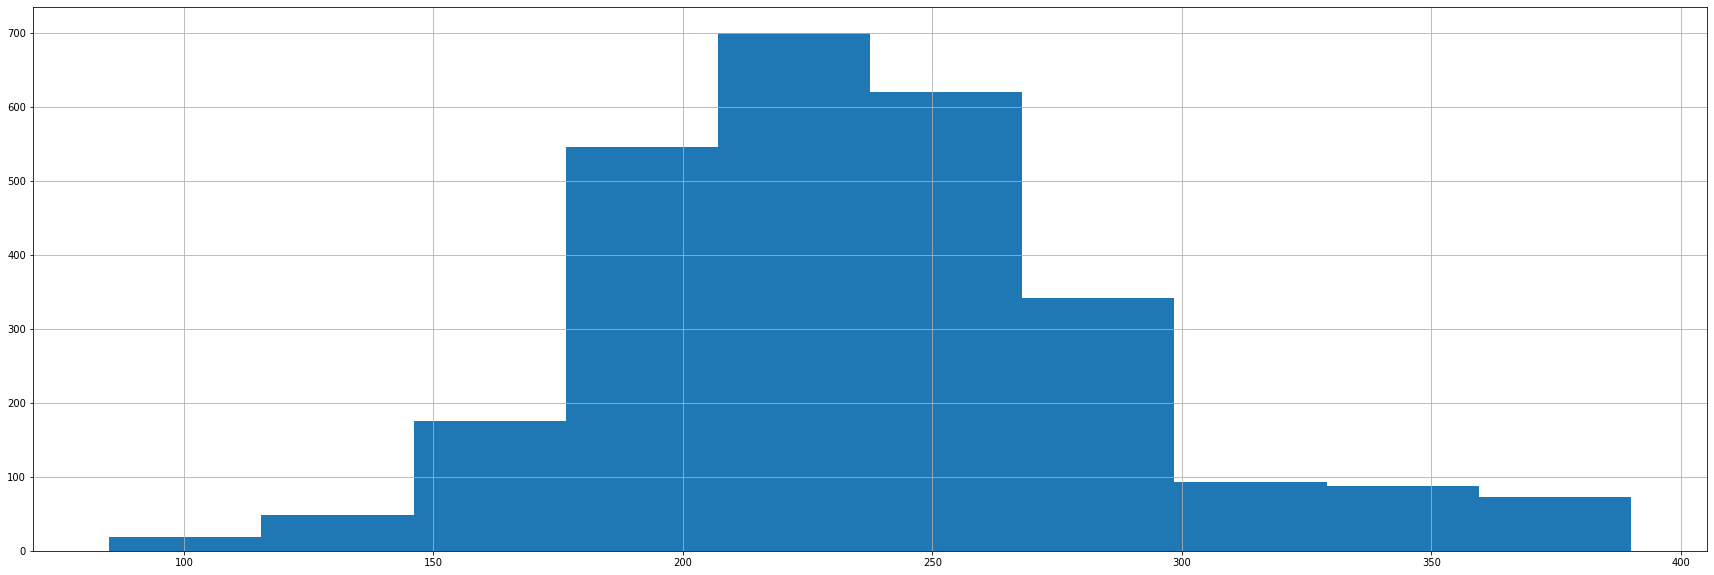

In [ ]:
short.hist()

In [ ]:
long.hist()

AttributeError: ignored

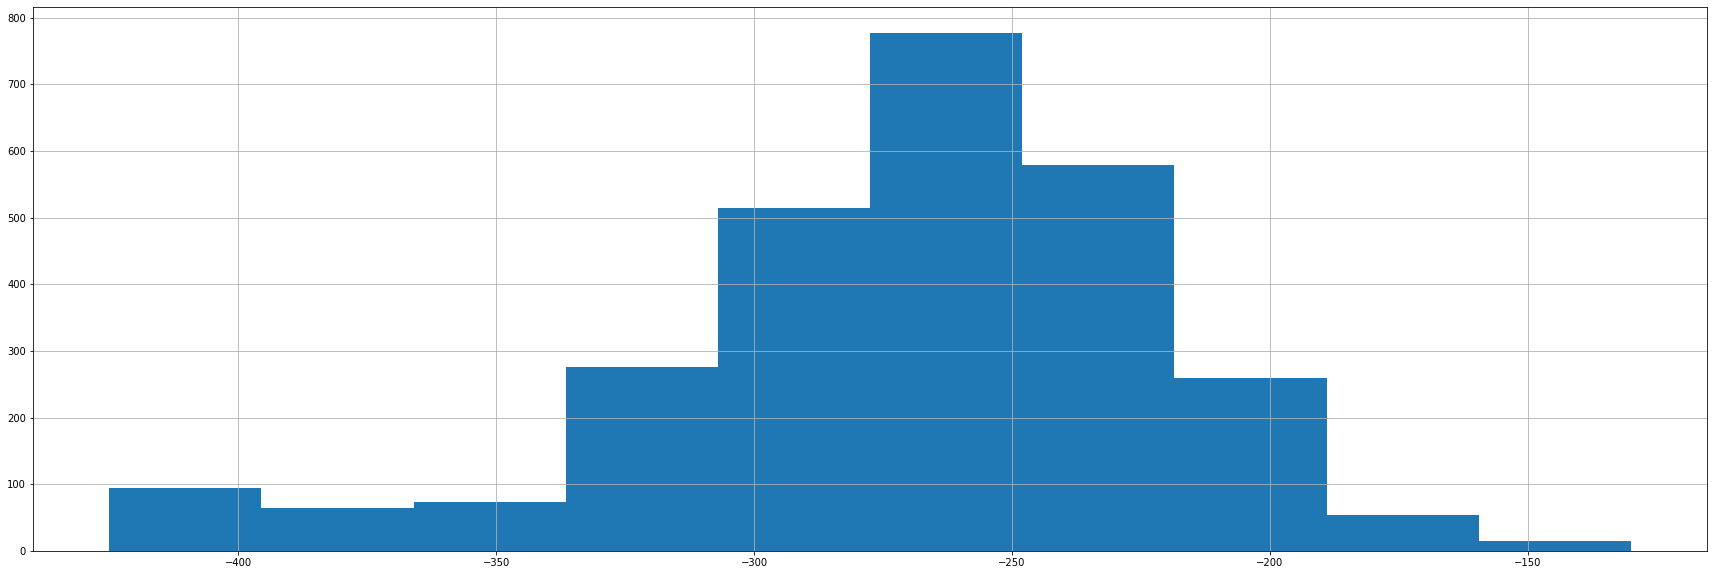

In [ ]:
long.hist()

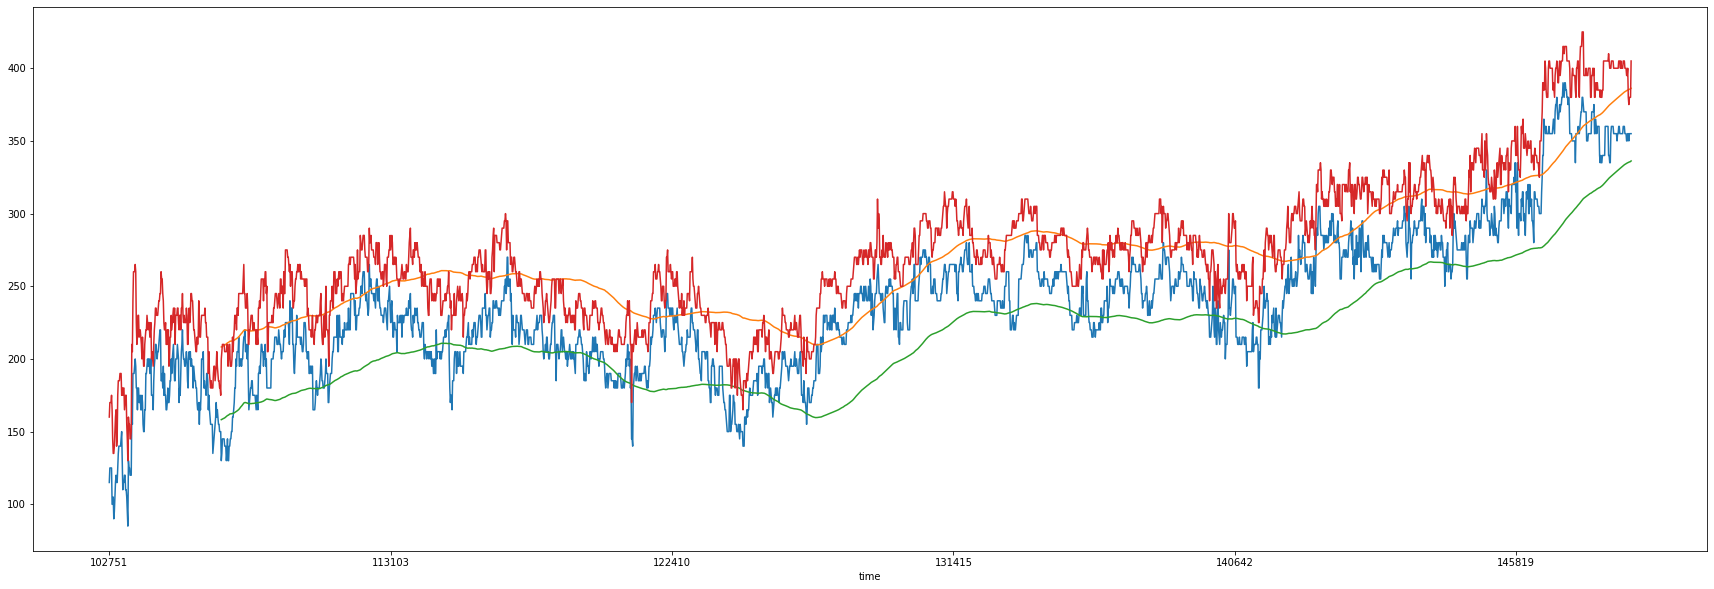

In [ ]:
short.plot()
(-long.rolling(window = 200).mean()).plot()
(-long.rolling(window = 200).mean()-50).plot()
(-long).plot()